In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from math import *
import csv
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from pandas import concat
from pandas import DataFrame

from math import sqrt
from numpy import concatenate


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [12]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [13]:
dataPath = "project\data\FinalData.csv"
data = pd.read_csv(dataPath)
data=data.iloc[:,2:4]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
reframed = series_to_supervised(scaled, 1, 1)
reframed

,var1(t-1),var2(t-1),var1(t),var2(t)
1,0.162162,0.15625,0.108108,0.21875
2,0.108108,0.21875,0.135135,0.18750
3,0.135135,0.18750,0.243243,0.18750
4,0.243243,0.18750,0.162162,0.21875
5,0.162162,0.21875,0.108108,0.21875
...,...,...,...,...
2744,0.459459,0.62500,0.513514,0.56250
2745,0.513514,0.56250,0.432432,0.62500
2746,0.432432,0.62500,0.486486,0.62500
2747,0.486486,0.62500,0.729730,0.71875


In [14]:
values = reframed.values
n_train_hours = 365*4
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-2], train[:, -2:]  
test_X, test_y = test[:, :-2], test[:, -2:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1460, 1, 2) (1460, 2) (1288, 1, 2) (1288, 2)


Epoch 1/100
30/30 - 2s - loss: 0.4505 - val_loss: 0.3559 - 2s/epoch - 70ms/step
Epoch 2/100
30/30 - 0s - loss: 0.2821 - val_loss: 0.1759 - 114ms/epoch - 4ms/step
Epoch 3/100
30/30 - 0s - loss: 0.1277 - val_loss: 0.1013 - 121ms/epoch - 4ms/step
Epoch 4/100
30/30 - 0s - loss: 0.0926 - val_loss: 0.0942 - 127ms/epoch - 4ms/step
Epoch 5/100
30/30 - 0s - loss: 0.0851 - val_loss: 0.0869 - 212ms/epoch - 7ms/step
Epoch 6/100
30/30 - 0s - loss: 0.0777 - val_loss: 0.0801 - 123ms/epoch - 4ms/step
Epoch 7/100
30/30 - 0s - loss: 0.0708 - val_loss: 0.0741 - 91ms/epoch - 3ms/step
Epoch 8/100
30/30 - 0s - loss: 0.0645 - val_loss: 0.0687 - 92ms/epoch - 3ms/step
Epoch 9/100
30/30 - 0s - loss: 0.0591 - val_loss: 0.0646 - 96ms/epoch - 3ms/step
Epoch 10/100
30/30 - 0s - loss: 0.0551 - val_loss: 0.0618 - 99ms/epoch - 3ms/step
Epoch 11/100
30/30 - 0s - loss: 0.0522 - val_loss: 0.0598 - 97ms/epoch - 3ms/step
Epoch 12/100
30/30 - 0s - loss: 0.0504 - val_loss: 0.0586 - 106ms/epoch - 4ms/step
Epoch 13/100
30/30 -

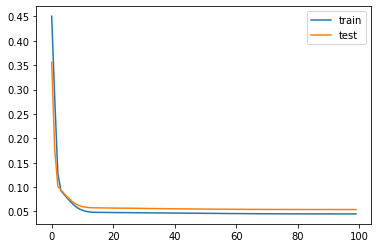

Test RMSE: 20.100
R²: 0.9011419898358228


[array([30.936941, 22.48553 ], dtype=float32),
 array([31.001839, 22.816751], dtype=float32),
 array([31.135195, 23.066309], dtype=float32),
 array([31.305523, 23.272709], dtype=float32),
 array([31.496115, 23.456406], dtype=float32),
 array([31.698076, 23.628262], dtype=float32),
 array([31.90668 , 23.794048], dtype=float32)]

In [15]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
yhatInverse = scaler.inverse_transform(yhat)
test_y_Inserve = scaler.inverse_transform(test_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(test_X, yhatInverse))
print('Test RMSE: %.3f' % rmse)
print("R²:",r2_score(test_y_Inserve,yhatInverse))
predictionTemperatureSeven=[]
predictionTemperatureSeven.append(yhatInverse[len(yhatInverse)-1])
predictionTemperatureSeven
for i in range(6):
    test = yhat.reshape(yhat.shape[0],1,yhat.shape[1])
    yhat = model.predict(test)
    yhatInverse = scaler.inverse_transform(yhat)
    predictionTemperatureSeven.append(yhatInverse[len(yhatInverse)-1])
predictionTemperatureSeven